In [150]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


# Statistical Modelling

This section of the project will look to set up the statistical models in order to make our predictions for the effectiveness of the bank's marketing campaign based on the dataframe that we have created.


We will begin by creating a Train, Validation and Test split of our data.

We will then look to implement a RFE to see if we should look to drop any of the features we have in our dataset.

Once this is complete, we will set up a baseline model using the Logistic Regression Learner.

We will then look to set up a Decision Tree, Guassian Naive Bayes, Random Forest and Bagged Tree models.

We will also look to hypertune each of the selected models in order to increase the performance of each.

Once all of this is completed, we will select our final model based on the best ROC-AUC score and move onto the threshold selection and model evaluation

In [468]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn import metrics
import seaborn as sns
import itertools
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report

In [357]:
def table(string, model_est, X_train, X_val):
    table = pd.DataFrame()
    
    train_accuracy = accuracy_score(y_train, model_est.predict(X_train))
    train_auc = roc_auc_score(y_train, model_est.predict_proba(X_train)[:,1])
    val_accuracy = accuracy_score(y_val, model_est.predict(X_val))
    val_auc = roc_auc_score(y_val, model_est.predict_proba(X_val)[:,1])
    table['Model'] = [string]
    table['Train Accuracy'] = train_accuracy
    table['Train AUC'] = train_auc
    table['Valudation Accuracy'] = val_accuracy
    table['Validation AUC'] = val_auc
    return table

In [377]:
def results_table (model_name, model_est, X_train, X_val):
    name_of_model = []
    train_acc = []
    val_acc = []
    train_auc = []
    val_auc =[]

    name_of_model.append(model_name)
    train_acc.append(accuracy_score(y_train, model_est.predict(X_train)))
    train_auc.append(roc_auc_score(y_train, model_est.predict_proba(X_train)[:,1]))
    val_acc.append(accuracy_score(y_val, model_est.predict(X_val)))
    val_auc.append(roc_auc_score(y_val, model_est.predict_proba(X_val)[:,1]))
        
    data = {"Model Name": model_name, "Train Accuracy" : train_acc, "Validation Accuracy" : val_acc, "Train ROC-AUC": train_auc, "Validation ROC-AUC": val_auc }
    table2 = pd.DataFrame(data)
    return table2

## Reading in the data 

In [252]:
#Reading in the data saved under data_feat and saving it under a variable called data.
data = pd.read_csv('/Users/naweedahmed/Desktop/Flatiron_Feb/capstone_project/dsc-capstone-submission-checklist/Data/data_feat.csv')

In [489]:
#Checking the data.
data.head()

,contact,month,day_of_week,duration,campaign,pdays,previous,cons_price_idx,cons_conf_idx,euribor3m,...,job_unemployed,age_group_16-24,age_group_25-34,age_group_35-44,age_group_45-54,age_group_55-64,age_group_65-74,age_group_75-79,Combined_Tax,Feature_2
0,1,5,1,261,1,999,0,93.994,-36.4,4.857,...,0,0,0,0,0,1,0,0,62.0,50914.6344
1,1,5,1,149,1,999,0,93.994,-36.4,4.857,...,0,0,0,0,0,1,0,0,62.0,50914.6344
2,1,5,1,226,1,999,0,93.994,-36.4,4.857,...,0,0,0,1,0,0,0,0,62.0,50914.6344
3,1,5,1,151,1,999,0,93.994,-36.4,4.857,...,0,0,0,1,0,0,0,0,62.0,50914.6344
4,1,5,1,307,1,999,0,93.994,-36.4,4.857,...,0,0,0,0,0,1,0,0,62.0,50914.6344


In [254]:
#Dropping unwanted columns.
data.drop(columns='Unnamed: 0', inplace=True)

In [255]:
#Checking the data.
data.head()

,contact,month,day_of_week,duration,campaign,pdays,previous,cons_price_idx,cons_conf_idx,euribor3m,...,job_unemployed,age_group_16-24,age_group_25-34,age_group_35-44,age_group_45-54,age_group_55-64,age_group_65-74,age_group_75-79,Combined_Tax,Feature_2
0,1,5,1,261,1,999,0,93.994,-36.4,4.857,...,0,0,0,0,0,1,0,0,62.0,50914.6344
1,1,5,1,149,1,999,0,93.994,-36.4,4.857,...,0,0,0,0,0,1,0,0,62.0,50914.6344
2,1,5,1,226,1,999,0,93.994,-36.4,4.857,...,0,0,0,1,0,0,0,0,62.0,50914.6344
3,1,5,1,151,1,999,0,93.994,-36.4,4.857,...,0,0,0,1,0,0,0,0,62.0,50914.6344
4,1,5,1,307,1,999,0,93.994,-36.4,4.857,...,0,0,0,0,0,1,0,0,62.0,50914.6344


In [256]:
#Checking the data.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 53 columns):
contact                     41188 non-null int64
month                       41188 non-null int64
day_of_week                 41188 non-null int64
duration                    41188 non-null int64
campaign                    41188 non-null int64
pdays                       41188 non-null int64
previous                    41188 non-null int64
cons_price_idx              41188 non-null float64
cons_conf_idx               41188 non-null float64
euribor3m                   41188 non-null float64
y                           41188 non-null int64
MOM_Inflation               41188 non-null float64
Wage_Growth                 41188 non-null float64
EURUSD                      41188 non-null float64
euro_zoneGDP_Growth_Rate    41188 non-null float64
loan_no                     41188 non-null int64
loan_yes                    41188 non-null int64
housing_no                  41188 non-null i

In [257]:
#Checking the data.
data.columns

Index(['contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'y',
       'MOM_Inflation', 'Wage_Growth', 'EURUSD', 'euro_zoneGDP_Growth_Rate',
       'loan_no', 'loan_yes', 'housing_no', 'housing_yes', 'marital_divorced',
       'marital_married', 'marital_single', 'poutcome_nonexistent',
       'poutcome_success', 'default_no', 'default_yes', 'edu_basic.4y',
       'edu_basic.6y', 'edu_basic.9y', 'edu_high.school', 'edu_illiterate',
       'edu_professional.course', 'edu_university.degree', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'age_group_16-24',
       'age_group_25-34', 'age_group_35-44', 'age_group_45-54',
       'age_group_55-64', 'age_group_65-74', 'age_group_75-79', 'Combined_Tax',
       'Feature_2'],
      dtype='object')

### Checking the value counts for our target variable 'y'.

In [258]:
#Checking value counts for y.
data['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64

We may have a class imbalance problem. We will look to address this by using class_weight in the hyperparameter section, and also look to use the SMOTE technique to address this.

## Assigning the X and y variables for our model.

In [360]:
X = data.drop(columns=['y'], axis=1)
y = data['y']

## Setting up the Train,Test and Validation splits.

In [362]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state = 42)

In [363]:
#Train Validation Split.
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.20, random_state = 42)

In [364]:
#Checking to see the size of each set.
print('Shapes of Each Set')
print('-------------------')
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_val: {X_val.shape}')
print(f'y_val: {y_val.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

Shapes of Each Set
-------------------
X_train: (26360, 52)
y_train: (26360,)
X_val: (6590, 52)
y_val: (6590,)
X_test: (8238, 52)
y_test: (8238,)


## Baseline Model

### Logistic Regression

In [366]:
logreg = LogisticRegression(penalty='none', solver='lbfgs')
log_reg = logreg.fit(X_train, y_train)
log_reg

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [367]:
log_reg_yval_pred = log_reg.predict(X_val)
log_reg_yval_predproba = log_reg.predict_proba(X_val)
print("Accuracy: ", accuracy_score(y_val, log_reg_yval_pred))
print("ROC_AUC of Baseline model (val) =", roc_auc_score(y_val, log_reg_yval_predproba[:,1]))

Accuracy:  0.9106221547799697
ROC_AUC of Baseline model (val) = 0.9057938116009897


In [388]:
results01 = table("Logistic Regression", log_reg, X_train, X_val)
results01

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Logistic Regression,0.906335,0.907303,0.910622,0.905794


## Improving the Baseline Model

### RFE

In [266]:
rfe = RFE(estimator=log_reg, step=1)
rfe = rfe.fit(X_train, y_train)

In [267]:

selected_rfe_features = pd.DataFrame({'Feature':list(X_train.columns),
                                      'Ranking':rfe.ranking_})
selected_rfe_features.sort_values(by='Ranking')

,Feature,Ranking
0,contact,1
50,Combined_Tax,1
28,edu_high.school,1
23,default_no,1
22,poutcome_success,1
21,poutcome_nonexistent,1
31,edu_university.degree,1
33,job_blue-collar,1
37,job_retired,1
16,housing_no,1


In [268]:
X_train.columns

Index(['contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'cons_price_idx', 'cons_conf_idx', 'euribor3m',
       'MOM_Inflation', 'Wage_Growth', 'EURUSD', 'euro_zoneGDP_Growth_Rate',
       'loan_no', 'loan_yes', 'housing_no', 'housing_yes', 'marital_divorced',
       'marital_married', 'marital_single', 'poutcome_nonexistent',
       'poutcome_success', 'default_no', 'default_yes', 'edu_basic.4y',
       'edu_basic.6y', 'edu_basic.9y', 'edu_high.school', 'edu_illiterate',
       'edu_professional.course', 'edu_university.degree', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'age_group_16-24',
       'age_group_25-34', 'age_group_35-44', 'age_group_45-54',
       'age_group_55-64', 'age_group_65-74', 'age_group_75-79', 'Combined_Tax',
       'Feature_2'],
      dtype='object')

In [269]:
X_train_rfe = rfe.transform(X_train)
X_val_rfe = rfe.transform(X_val)

In [270]:
log_reg_rfe_model = log_reg.fit(X_train_rfe, y_train)

In [271]:
rfecv = RFECV(estimator=log_reg, step=1, cv=5, scoring='accuracy')
rfecv = rfecv.fit(X_train, y_train)
print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Optimal number of features : 52
Best features : Index(['contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'cons_price_idx', 'cons_conf_idx', 'euribor3m',
       'MOM_Inflation', 'Wage_Growth', 'EURUSD', 'euro_zoneGDP_Growth_Rate',
       'loan_no', 'loan_yes', 'housing_no', 'housing_yes', 'marital_divorced',
       'marital_married', 'marital_single', 'poutcome_nonexistent',
       'poutcome_success', 'default_no', 'default_yes', 'edu_basic.4y',
       'edu_basic.6y', 'edu_basic.9y', 'edu_high.school', 'edu_illiterate',
       'edu_professional.course', 'edu_university.degree', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'age_group_16-24',
       'age_group_25-34', 'age_group_35-44', 'age_group_45-54',
       'age_group_55-64', 'age_group_65-74', 'age_group_75-79', 'Combined_Tax',
    

In [272]:
rfecv.grid_scores_

array([0.88918816, 0.8952959 , 0.89525797, 0.89567527, 0.89559939,
       0.8965478 , 0.89643399, 0.89635812, 0.89662367, 0.89688923,
       0.89707891, 0.89647193, 0.89647193, 0.89662367, 0.89635812,
       0.89628225, 0.89609256, 0.89586495, 0.89590288, 0.89582701,
       0.89609256, 0.89594082, 0.89616844, 0.89594082, 0.89590288,
       0.89616844, 0.89559939, 0.89563733, 0.89601669, 0.89962064,
       0.89943096, 0.89905159, 0.90094841, 0.90045524, 0.90030349,
       0.90037936, 0.90045524, 0.90053111, 0.89981032, 0.89981032,
       0.90254173, 0.90208649, 0.90155539, 0.90314871, 0.9026176 ,
       0.90572838, 0.90618361, 0.9064871 , 0.90667678, 0.90660091,
       0.90679059, 0.9069044 ])

The RFE model suggests that we keep all 52 features in our model. We will proceed on this basis.

### Logistic Regression Hyperparameter Tuning

#### Iteration 1:

In [273]:
param_grid01 = {'C': [0.01,0.1,1,10,100],
             'penalty': ['l1','l2'],
             'solver': ['liblinear','saga']}

In [274]:
log_reg_gs01 = GridSearchCV(log_reg,
                         param_grid01,
                         cv=5,
                         scoring='roc_auc',
                         return_train_score=True,
                         )

log_reg_gs01.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='none',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

In [275]:
log_reg_gs01_model = log_reg_gs01.best_estimator_
log_reg_gs01_model

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [276]:
#Checking to see the parameters and R-Squared
print(f'best model:{log_reg_gs01.best_params_}')
print(f'best score: {log_reg_gs01.best_score_}')

best model:{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
best score: 0.9253814911890726


In [277]:
log_reg_gs01_yval_pred = log_reg_gs01_model.predict(X_val)
log_reg_gs01_yval_predprob = log_reg_gs01_model.predict_proba(X_val)
print("Accuracy:", accuracy_score(y_val, log_reg_gs01_yval_pred))
print("ROC_AUC of model:", roc_auc_score(y_val, log_reg_gs01_yval_predprob[:,1]))

Accuracy: 0.9124430955993931
ROC_AUC of model: 0.9256669868473937


In [389]:
results02 = table("Logistic Regression GS 01", log_reg_gs01_model, X_train, X_val)
results02

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Logistic Regression GS 01,0.907739,0.92665,0.912443,0.925667


#### Iteration 2:

In [279]:
param_grid02 = {'C': [0.5,1,5,10],
             'penalty': ['l1','l2'],
             'solver': ['liblinear','saga']}

In [280]:
log_reg_gs02 = GridSearchCV(log_reg,
                         param_grid02,
                         cv=5,
                         scoring='roc_auc',
                         return_train_score=True)

log_reg_gs02.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='none',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.5, 1, 5, 10], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

In [281]:
log_reg_gs02_model = log_reg_gs02.best_estimator_
log_reg_gs02_model

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [282]:
log_reg_gs02_yval_pred = log_reg_gs02_model.predict(X_val)
log_reg_gs02_yval_predprob = log_reg_gs02_model.predict_proba(X_val)
print("Accuracy:", accuracy_score(y_val, log_reg_gs02_yval_pred))
print("ROC_AUC of model:", roc_auc_score(y_val, log_reg_gs02_yval_predprob[:,1]))

Accuracy: 0.9121396054628225
ROC_AUC of model: 0.9256854233575835


In [390]:
results03 = table("Logistic Regression GS 02", log_reg_gs02_model, X_train, X_val)
results03

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Logistic Regression GS 02,0.907625,0.926646,0.91214,0.925685


#### Iteration 3:

In [284]:
param_grid03 = {'C': [0.5,1,5],
             'penalty': ['l1','l2'],
             'solver': ['liblinear','saga'],
            'class_weight': [None,'balanced'],
            
             }

In [285]:
log_reg_gs03 = GridSearchCV(log_reg,
                         param_grid03,
                         cv=5,
                         scoring='roc_auc',
                         return_train_score=True)

log_reg_gs03.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='none',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.5, 1, 5], 'class_weight': [None, 'balanced'],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

In [286]:
log_reg_gs03_model = log_reg_gs03.best_estimator_
log_reg_gs03_model

LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [287]:
log_reg_gs03_yval_pred = log_reg_gs03_model.predict(X_val)
log_reg_gs03_yval_predprob = log_reg_gs03_model.predict_proba(X_val)
print("Accuracy:", accuracy_score(y_val, log_reg_gs03_yval_pred))
print("ROC_AUC of model:", roc_auc_score(y_val, log_reg_gs03_yval_predprob[:,1]))

Accuracy: 0.857814871016692
ROC_AUC of model: 0.928752567284044


In [391]:
results04 = table("Logistic Regression GS 03", log_reg_gs03_model, X_train, X_val)
results04

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Logistic Regression GS 03,0.855349,0.92974,0.857815,0.928753


#### Logistic Regression Hyperparameter Results Summary

In [439]:
cm01 = sns.light_palette("blue", as_cmap=True)

In [440]:
log_reg_df = pd.DataFrame()
log_reg_df.append([results01, 
                   results02, 
                   results03, 
                   results04],
                  ignore_index=True).style.background_gradient(cmap=cm01).highlight_max(color='red')

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Logistic Regression,0.906335,0.907303,0.910622,0.905794
1,Logistic Regression GS 01,0.907739,0.92665,0.912443,0.925667
2,Logistic Regression GS 02,0.907625,0.926646,0.91214,0.925685
3,Logistic Regression GS 03,0.855349,0.92974,0.857815,0.928753


As can be seen in the table above, the best performing model out of the hyperparameter tuned Logistic Regression is from log_reg_gs03_model.

We will now move onto Decision Trees

### Decision Tree

In [289]:
dec_tree = DecisionTreeClassifier(criterion='entropy')

dec_tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [290]:
dec_tree_yval_pred = dec_tree.predict(X_val)
dec_tree_y_val_predprob = dec_tree.predict_proba(X_val)
print('Accuracy: ', accuracy_score(y_val, dec_tree_yval_pred))
print("ROC_AUC of Baseline model (val) =", roc_auc_score(y_val, dec_tree_yval_predproba[:,1]))

Accuracy:  0.8893778452200304
ROC_AUC of Baseline model (val) = 0.7219808831825841


In [392]:
results05 = table("Decision Tree", dec_tree, X_train, X_val)
results05

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Decision Tree,1.0,1.0,0.889378,0.727628


In [291]:
table("Decision Tree", dec_tree, X_train, X_val)

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Decision Tree,1.0,1.0,0.889378,0.727628


### Decision Tree Hyperparameter Tuning

#### Iteration 1:

In [292]:
param_grid04 = {'max_depth':[1,10,100],
                             'min_samples_leaf':[5,10,50]}

In [293]:
dec_tree_gs01 = GridSearchCV(dec_tree,
                         param_grid04,
                         cv=5,
                         scoring='roc_auc',
                         return_train_score=True)

dec_tree_gs01.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='entropy',
                                              max_depth=None, max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [1, 10, 100],
                       

In [294]:
dec_tree_gs01_model = dec_tree_gs01.best_estimator_
dec_tree_gs01_model

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [295]:
dec_tree_gs01_yval_pred = dec_tree_gs01_model.predict(X_val)
dec_tree_gs01_yval_predprob = dec_tree_gs01_model.predict_proba(X_val)
print('Accuracy: ', accuracy_score(y_val, dec_tree_gs01_yval_pred))
print("ROC_AUC of Baseline model (val) =", roc_auc_score(y_val, dec_tree_gs01_yval_predprob[:,1]))

Accuracy:  0.9057663125948406
ROC_AUC of Baseline model (val) = 0.9311328359777434


In [393]:
results06 = table("Decision Tree GS 01", dec_tree_gs01, X_train, X_val)
results06

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Decision Tree GS 01,0.920675,0.954606,0.905766,0.931133


In [296]:
table('Decision Tree GS01', dec_tree_gs01, X_train, X_val)

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Decision Tree GS01,0.920675,0.954606,0.905766,0.931133


#### Iteration 2:

In [297]:
param_grid05 = {'max_depth':range(10, 20,30),
                             'min_samples_leaf':[15,20,25,30]}

In [298]:
dec_tree_gs02 = GridSearchCV(dec_tree,
                         param_grid05,
                         cv=5,
                         scoring='roc_auc',
                         return_train_score=True)

dec_tree_gs02.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='entropy',
                                              max_depth=None, max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': range(10, 20, 30),
                  

In [299]:
dec_tree_gs02_model = dec_tree_gs02.best_estimator_
dec_tree_gs02_model

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=30, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [300]:
dec_tree_gs02_yval_pred = dec_tree_gs02_model.predict(X_val)
dec_tree_gs02_yval_predproba = dec_tree_gs02_model.predict_proba(X_val)[:,1]
print('Accuracy: ', accuracy_score(y_val, dec_tree_gs02_yval_pred))
print('ROC_AUC Score: ', roc_auc_score(y_val, dec_tree_gs02_yval_predproba))

Accuracy:  0.9048558421851289
ROC_AUC Score:  0.9274786044299246


In [394]:
results07 = table("Decision Tree GS 02", dec_tree_gs02, X_train, X_val)
results07

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Decision Tree GS 02,0.924659,0.958665,0.904856,0.927479


In [301]:
table('Decision Tree GS02', dec_tree_gs02, X_train, X_val)

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Decision Tree GS02,0.924659,0.958665,0.904856,0.927479


#### Iteration 3:

In [302]:
param_grid06 = {'max_depth':range(10,50+1,10),
                'min_samples_leaf':[5,10,15,20],
               'class_weight': [None,'balanced'],
               'criterion': ['gini','entropy']}

In [303]:
dec_tree_gs03 = GridSearchCV(dec_tree,
                         param_grid06,
                         cv=5,
                         scoring='roc_auc',
                         return_train_score=True)

dec_tree_gs03.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='entropy',
                                              max_depth=None, max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'class_weight': [None, 'balanced'],
              

In [304]:
dec_tree_gs03_model = dec_tree_gs03.best_estimator_
dec_tree_gs03_model

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [305]:
dec_tree_gs03_yval_pred = dec_tree_gs03_model.predict(X_val)
dec_tree_gs03_yval_predprob = dec_tree_gs03_model.predict_proba(X_val)
print('Accuracy: ', accuracy_score(y_val, dec_tree_gs03_yval_pred))
print("ROC_AUC of Baseline model (val) =", roc_auc_score(y_val, dec_tree_gs03_yval_predprob[:,1]))

Accuracy:  0.9071320182094081
ROC_AUC of Baseline model (val) = 0.9250039638496909


In [395]:
results08 = table("Decision Tree GS 03", dec_tree_gs03, X_train, X_val)
results08

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Decision Tree GS 03,0.926897,0.961602,0.907132,0.925004


In [306]:
table('Decision Tree GS03', dec_tree_gs03, X_train, X_val)

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Decision Tree GS03,0.926897,0.961602,0.907132,0.925004


#### Decision Tree Hyperparameter Results Summary

In [443]:
cm02 = sns.light_palette("green", as_cmap=True)

In [444]:
dec_tree_df = pd.DataFrame()
dec_tree_df.append([results05, 
                    results06, 
                    results07, 
                    results08]
                   ,ignore_index=True).style.background_gradient(cmap=cm02).highlight_max(color='red')

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Decision Tree,1,1,0.889378,0.727628
1,Decision Tree GS 01,0.920675,0.954606,0.905766,0.931133
2,Decision Tree GS 02,0.924659,0.958665,0.904856,0.927479
3,Decision Tree GS 03,0.926897,0.961602,0.907132,0.925004


Our best performing model out of the Decision Tree hyperparameter tuned models is dec_tree_gs03_model.

### Gaussian Naive Bayes

In [344]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [345]:
GNB_yval_pred = gnb.predict(X_val)
GNB_yval_predprob = gnb.predict_proba(X_val)
print("Accuracy:",metrics.accuracy_score(y_val, GNB_yval_pred))
print("ROC_AUC of Baseline model (test) =", roc_auc_score(y_val, GNB_yval_predprob[:,1]))

Accuracy: 0.8904400606980273
ROC_AUC of Baseline model (test) = 0.8815345905804182


In [396]:
results09 = table("Gaussian Naive Bayes", gnb, X_train, X_val)
results09

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Gaussian Naive Bayes,0.890592,0.880637,0.89044,0.881535


In [346]:
table("Gaussian Naive Bayes", gnb, X_train, X_val)

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Gaussian Naive Bayes,0.890592,0.880637,0.89044,0.881535


### Random Forest

In [312]:
ran_for = RandomForestClassifier()
ran_for.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [313]:
ran_for.score(X_train, y_train)

0.9999620637329287

In [402]:
results10 = table("Random Forest", ran_for, X_train, X_val)
results10

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Random Forest,0.999962,1.0,0.913202,0.940703


In [315]:
table('Random Forest', ran_for, X_train, X_val)

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Random Forest,0.999962,1.0,0.913202,0.940703


### Random Forest Hyperparameter Tuning

#### Iteration 1:

In [318]:
param_grid08 = {'max_depth':range(10,50+1,10),
                'min_samples_leaf':[5,10,15,20],
                'criterion':['gini', "entropy"],
               'class_weight': [None,'balanced']}

In [319]:
ran_for_gs01 = GridSearchCV(ran_for,
                         param_grid08,
                         cv=5,
                         scoring='roc_auc',
                         return_train_score=True)

ran_for_gs01.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [320]:
ran_for_gs01_model = ran_for_gs01.best_estimator_
ran_for_gs01_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [321]:
table("Random Forest GS01",ran_for_gs01, X_train, X_val)

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Random Forest GS01,0.914226,0.982971,0.887557,0.946328


In [322]:
ran_for_gs01_yval_pred = ran_for_gs01_model.predict(X_val)
ran_for_gs01_yval_predprob = ran_for_gs01_model.predict_proba(X_val)
print('Accuracy: ', accuracy_score(y_val, ran_for_gs01_yval_pred))
print("ROC_AUC of Baseline model (val) =", roc_auc_score(y_val, ran_for_gs01_yval_predprob[:,1]))

Accuracy:  0.887556904400607
ROC_AUC of Baseline model (val) = 0.9463280924480367


In [403]:
results11 = table("Random Forest GS01", ran_for_gs01, X_train, X_val)
results11

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Random Forest GS01,0.914226,0.982971,0.887557,0.946328


#### Iteration 2:

In [323]:
param_grid09 = {'max_depth':[30,40,50],
                'min_samples_leaf':[3,5,10],
                'criterion':['gini', "entropy"],
               'class_weight': [None,'balanced']}

In [324]:
ran_for_gs02 = GridSearchCV(ran_for,
                         param_grid09,
                         cv=5,
                         scoring='roc_auc',
                         return_train_score=True)

ran_for_gs02.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [325]:
ran_for_gs02_model = ran_for_gs02.best_estimator_
ran_for_gs02_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [326]:
ran_for_gs02_yval_pred = ran_for_gs02_model.predict(X_val)
ran_for_gs02_yval_predprob = ran_for_gs02_model.predict_proba(X_val)
print('Accuracy: ', accuracy_score(y_val, ran_for_gs02_yval_pred))
print("ROC_AUC of Baseline model (val) =", roc_auc_score(y_val, ran_for_gs02_yval_predprob[:,1]))

Accuracy:  0.8884673748103187
ROC_AUC of Baseline model (val) = 0.9461672338966302


In [327]:
ran_for_gs02_ytrain_pred = ran_for_gs02_model.predict(X_train)
ran_for_gs02_ytrain_predprob = ran_for_gs02_model.predict_proba(X_train)
print('Accuracy: ', accuracy_score(y_train, ran_for_gs02_ytrain_pred))
print("ROC_AUC of Baseline model (train) =", roc_auc_score(y_train, ran_for_gs02_ytrain_predprob[:,1]))

Accuracy:  0.9151745068285281
ROC_AUC of Baseline model (train) = 0.9837210971906062


In [328]:
ran_for_gs02_ytest_pred = ran_for_gs02_model.predict(X_test)
ran_for_gs02_ytest_predprob = ran_for_gs02_model.predict_proba(X_test)
print('Accuracy: ', accuracy_score(y_test, ran_for_gs02_ytest_pred))
print("ROC_AUC of Baseline model (test) =", roc_auc_score(y_test, ran_for_gs02_ytest_predprob[:,1]))

Accuracy:  0.885773245933479
ROC_AUC of Baseline model (test) = 0.9453622092159034


In [404]:
results12 = table("Random Forest GS02", ran_for_gs02, X_train, X_val)
results12

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Random Forest GS02,0.915175,0.983721,0.888467,0.946167


In [329]:
table("Random Forest GS02", ran_for_gs02_model, X_train, X_val)

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Random Forest GS02,0.915175,0.983721,0.888467,0.946167


#### Iteration 3:

In [504]:
param_grid10 = {'max_depth':[40,50,100],
                'min_samples_leaf':[3,5,10],
                'criterion':['gini', "entropy"],
               'class_weight': [None,'balanced']}

In [505]:
ran_for_gs03 = GridSearchCV(ran_for,
                         param_grid10,
                         cv=5,
                         scoring='roc_auc',
                         return_train_score=True)

ran_for_gs03.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [506]:
ran_for_gs03_model = ran_for_gs03.best_estimator_
ran_for_gs03_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=100, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [507]:
ran_for_gs03_yval_pred = ran_for_gs03_model.predict(X_val)
ran_for_gs03_yval_predprob = ran_for_gs03_model.predict_proba(X_val)
print('Accuracy: ', accuracy_score(y_val, ran_for_gs03_yval_pred))
print("ROC_AUC of Baseline model (val) =", roc_auc_score(y_val, ran_for_gs03_yval_predprob[:,1]))

Accuracy:  0.9
ROC_AUC of Baseline model (val) = 0.9469060770424889


In [508]:
results13 = table("Random Forest GS03", ran_for_gs03, X_train, X_val)
results13

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Random Forest GS03,0.945258,0.992683,0.9,0.946906


In [509]:
table("Random Forest GS04", ran_for_gs03_model, X_train, X_val)

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Random Forest GS04,0.945258,0.992683,0.9,0.946906


#### Iteration 4:

In [335]:
param_grid11 = {'max_depth':[50,100,150],
                'min_samples_leaf':[3,5,10],
                'criterion':['gini', "entropy"],
               'class_weight': [None,'balanced']}

In [336]:
ran_for_gs04 = GridSearchCV(ran_for,
                         param_grid11,
                         cv=5,
                         scoring='roc_auc',
                         return_train_score=True)

ran_for_gs04.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [337]:
ran_for_gs04_model = ran_for_gs04.best_estimator_
ran_for_gs04_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=150, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [338]:
ran_for_gs04_yval_pred = ran_for_gs04_model.predict(X_val)
ran_for_gs04_yval_predprob = ran_for_gs04_model.predict_proba(X_val)
print('Accuracy: ', accuracy_score(y_val, ran_for_gs04_yval_pred))
print("ROC_AUC of Baseline model (val) =", roc_auc_score(y_val, ran_for_gs04_yval_predprob[:,1]))

Accuracy:  0.8871016691957512
ROC_AUC of Baseline model (val) = 0.9463032031592803


In [406]:
results14 = table("Random Forest GS04", ran_for_gs04, X_train, X_val)
results14

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Random Forest GS04,0.915819,0.983771,0.887102,0.946303


In [339]:
table("Random Forest GS04", ran_for_gs04_model, X_train, X_val)

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Random Forest GS04,0.915819,0.983771,0.887102,0.946303


In [510]:
cm03 = sns.light_palette("yellow", as_cmap=True)

In [511]:
ran_for_df = pd.DataFrame()
ran_for_df.append([results10, 
                    results11, 
                    results12, 
                    results13,
                    results14]
                   ,ignore_index=True).style.background_gradient(cmap=cm03).highlight_max(color='red')

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Random Forest,0.999962,1,0.913202,0.940703
1,Random Forest GS01,0.914226,0.982971,0.887557,0.946328
2,Random Forest GS02,0.915175,0.983721,0.888467,0.946167
3,Random Forest GS03,0.945258,0.992683,0.9,0.946906
4,Random Forest GS04,0.915819,0.983771,0.887102,0.946303


Our best performing model out of the Randome Forest hyperparameter tuned models is ran_for_gs03_model.

## Ensemble Methods

### Bagged Tree

In [307]:
bag_tree =  BaggingClassifier(DecisionTreeClassifier())

In [308]:
bag_tree.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,


In [309]:
bag_tree.score(X_train, y_train)

0.9930576631259485

In [310]:
bag_tree.score(X_val, y_val)

0.910773899848255

In [407]:
results15 = table("Bagged Tree", bag_tree, X_train, X_val)
results15

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Bagged Tree,0.993058,0.999656,0.910774,0.911457


In [311]:
table('Bagged Tree', bag_tree, X_train, X_val)

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Bagged Tree,0.993058,0.999656,0.910774,0.911457


### XG Boost

In [341]:
xgb = xgb.XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [342]:
xgb_yval_pred = clf.predict(X_val)
xgb_yval_predprob = clf.predict_proba(X_val)
print('Accuracy: ', accuracy_score(y_val, xgb_yval_pred))
print("ROC_AUC of Baseline model (val) =", roc_auc_score(y_val, xgb_yval_predprob[:,1]))

Accuracy:  0.9165402124430956
ROC_AUC of Baseline model (val) = 0.9457102389002989


In [408]:
results16 = table("XG Boost", xgb, X_train, X_val)
results16

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,XG Boost,0.964833,0.987886,0.91654,0.94571


In [343]:
table("XGBoost", xgb, X_train, X_val)

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,XGBoost,0.964833,0.987886,0.91654,0.94571


### Voting Classifiers

In [415]:
clf1 = log_reg_gs03_model
clf2 = dec_tree_gs03_model
clf3 = gnb
clf4 = ran_for_gs03_model

In [416]:
vc =  VotingClassifier(estimators=[('lr', clf1), ('dt', clf2), ('gnb', clf3), ('rf',clf4)], voting='hard')
vc.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1, class_weight='balanced',
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l1',
                                                 random_state=None,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('dt',
                              DecisionTreeClassifier(ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion...
                                        

In [417]:
vc_ytrain_pred = vc_model.predict(X_train)
vc_ytrain_predprob = vc_model.predict_proba(X_train)
print('Accuracy: ', accuracy_score(y_train, vc_ytrain_pred))
print("ROC_AUC of Baseline model (val) =", roc_auc_score(y_train, vc_ytrain_predprob[:,1]))

Accuracy:  0.9162746585735964
ROC_AUC of Baseline model (val) = 0.983337831690362


In [418]:
vc_yval_pred = vc_model.predict(X_val)
vc_yval_predprob = vc_model.predict_proba(X_val)
print('Accuracy: ', accuracy_score(y_val, vc_yval_pred))
print("ROC_AUC of Baseline model (val) =", roc_auc_score(y_val, vc_yval_predprob[:,1]))

Accuracy:  0.8878603945371776
ROC_AUC of Baseline model (val) = 0.9453518792334836


In [419]:
vc_ytest_pred = vc_model.predict(X_test)
vc_ytest_predprob = vc_model.predict_proba(X_test)
print('Accuracy: ', accuracy_score(y_test, vc_ytest_pred))
print("ROC_AUC of Baseline model (val) =", roc_auc_score(y_test, vc_ytest_predprob[:,1]))

Accuracy:  0.8871085214857976
ROC_AUC of Baseline model (val) = 0.9453151257889036


In [421]:
results17 = table("Voting Classifier", vc_model, X_train, X_val)
results17

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Voting Classifier,0.916275,0.983338,0.88786,0.945352


In [352]:
table("Voting CLassifier", vc_model, X_train, X_val)

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Voting CLassifier,0.916275,0.983338,0.88786,0.945352


## Summarising all the models

In [512]:
cm = sns.light_palette("purple", as_cmap=True)

In [513]:
results_summary = pd.DataFrame()
results_summary.append([results01,
                        results02, 
                        results03,
                        results04,
                        results05,
                        results06,
                        results07,
                        results08,
                        results09,
                        results10,
                        results11, 
                        results12, 
                        results13, 
                        results14, 
                        results15, 
                        results16, 
                        results17], ignore_index=True).style.background_gradient(cmap=cm).highlight_max(color='red')

,Model,Train Accuracy,Train AUC,Valudation Accuracy,Validation AUC
0,Logistic Regression,0.906335,0.907303,0.910622,0.905794
1,Logistic Regression GS 01,0.907739,0.92665,0.912443,0.925667
2,Logistic Regression GS 02,0.907625,0.926646,0.91214,0.925685
3,Logistic Regression GS 03,0.855349,0.92974,0.857815,0.928753
4,Decision Tree,1,1,0.889378,0.727628
5,Decision Tree GS 01,0.920675,0.954606,0.905766,0.931133
6,Decision Tree GS 02,0.924659,0.958665,0.904856,0.927479
7,Decision Tree GS 03,0.926897,0.961602,0.907132,0.925004
8,Gaussian Naive Bayes,0.890592,0.880637,0.89044,0.881535
9,Random Forest,0.999962,1,0.913202,0.940703


## Interpretting the best performing model

In [514]:
ran_for_gs03_model.feature_importances_

array([1.21988782e-02, 2.44041757e-02, 2.18044100e-02, 4.01002276e-01,
       2.44130205e-02, 1.83153142e-02, 8.31507206e-03, 3.29875579e-02,
       3.32342672e-02, 9.47290106e-02, 1.04263776e-02, 3.27357601e-02,
       3.41167415e-02, 1.88160148e-02, 4.86002028e-03, 4.41997218e-03,
       7.39937527e-03, 7.72652579e-03, 3.71415597e-03, 6.91825555e-03,
       6.80347272e-03, 6.21896104e-03, 1.66693717e-02, 8.14400294e-03,
       0.00000000e+00, 3.47035305e-03, 2.26353510e-03, 4.54190473e-03,
       6.66896040e-03, 0.00000000e+00, 4.52370393e-03, 7.36114984e-03,
       6.53255258e-03, 5.67980013e-03, 1.39170558e-03, 1.09298756e-03,
       2.97407208e-03, 2.94394328e-03, 1.87776169e-03, 3.99042786e-03,
       2.04034624e-03, 5.30242714e-03, 1.19170471e-03, 1.72612638e-03,
       7.57215179e-03, 9.16389938e-03, 6.50446995e-03, 3.33902409e-03,
       6.93876181e-04, 2.18480731e-04, 3.33144943e-03, 6.32301965e-02])

In [533]:
features_df = pd.DataFrame(ran_for_gs03_model.feature_importances_, X.columns).rename(columns={0:'Importance'}).sort_values('Importance', ascending=False)

In [534]:
features_df.head()

,Importance
duration,0.401002
euribor3m,0.094729
Feature_2,0.063230
EURUSD,0.034117
cons_conf_idx,0.033234


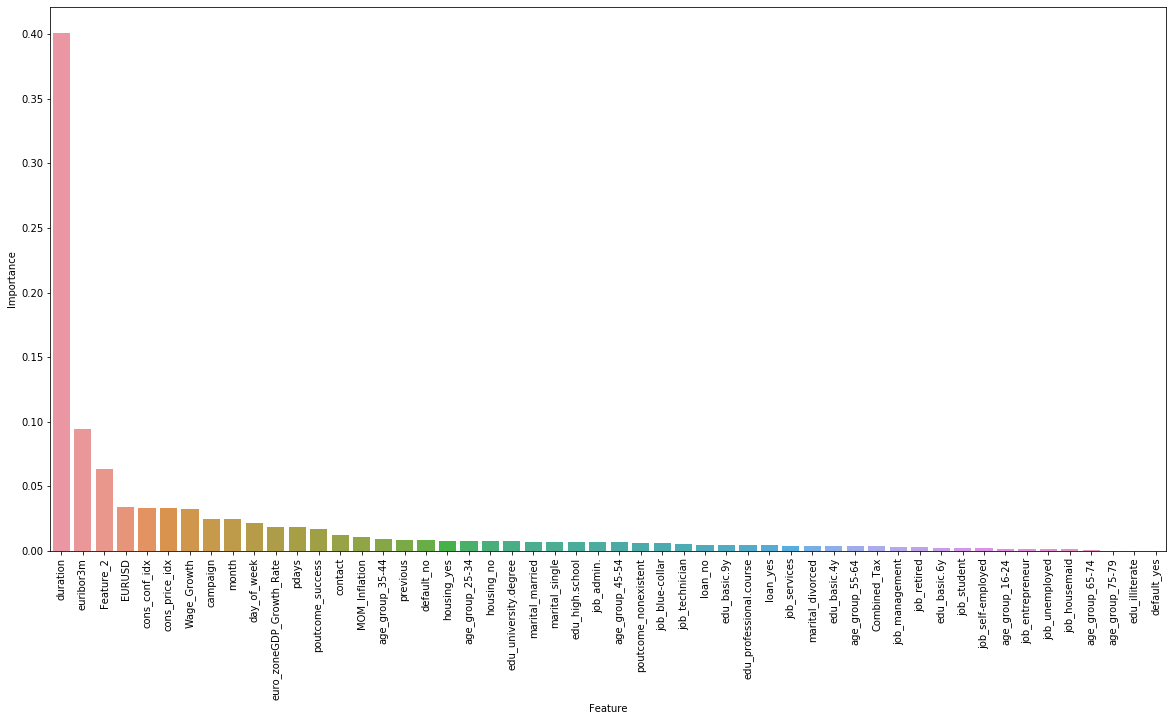

In [545]:
n_features = X.shape[1]
plt.figure(figsize=(20,10))
sns.barplot(features_df.index, features_df['Importance'],data=features_df)
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.show()

Based on the feature importance plot, it looks like 